<a href="https://colab.research.google.com/github/Syed-Bilal-Hussaini/1.Stock-Price-Trend-Prediction-with-LSTM/blob/main/1_Stock_Price_Trend_Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout

ticker = 'AAPL'
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")

print(f"Retrieved {len(data)} rows of data for {ticker}")
data.head()

/tmp/ipython-input-352033822.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Retrieved 2516 rows of data for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.214895,24.682228,23.776355,24.671153,212818400
2015-01-05,23.532724,24.064287,23.346678,23.984553,257142000
2015-01-06,23.534941,23.794077,23.173920,23.596956,263188400
2015-01-07,23.864939,23.964606,23.632379,23.743122,160423600
2015-01-08,24.781893,24.839479,24.075357,24.192745,237458000


In [2]:
# Calculate Moving Average (20-day)
data['MA20'] = data['Close'].rolling(window=20).mean()

# Calculate RSI (14-day)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values created by indicators
data.dropna(inplace=True)

In [3]:
data

Price,Close,High,Low,Open,Volume,MA20,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2015-01-30,25.949110,26.578125,25.880449,26.223750,334982000,24.505370,58.434280
2015-02-02,26.274698,26.394300,25.709914,26.146239,250956400,24.608360,66.039708
2015-02-03,26.279121,26.376573,26.048777,26.245898,207662800,24.745680,64.899265
2015-02-04,26.480680,26.691092,26.203825,26.245907,280598800,24.892967,66.956296
2015-02-05,26.669680,26.734164,26.516252,26.687467,168984800,25.033204,75.500295
...,...,...,...,...,...,...,...
2024-12-24,256.797211,256.807136,253.903002,254.101927,23234700,244.955383,76.180715
2024-12-26,257.612732,258.686881,256.230300,256.787255,27237100,246.146873,76.812153


In [4]:
# Select features for the model
features = ['Close', 'MA20', 'RSI']
dataset = data[features].values

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training sequences (Using a 60-day window)
prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, :]) # Previous 60 days
    y_train.append(scaled_data[x, 0]) # Predicting the 'Close' price

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

In [5]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], len(features))),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1) # Final output: The predicted price
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0439
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0027
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0021
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0018
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0015
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0016
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0013
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0014
Epoch 9/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0012
Epoch 10/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0011
Epoch 11/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0010
Epoch 12/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0013
Epoch 13/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 9.9725e-04
Epoch 14/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 9.1481e-04
Epoch 15/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 9.4

In [6]:
model.save('stock_model.h5')

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


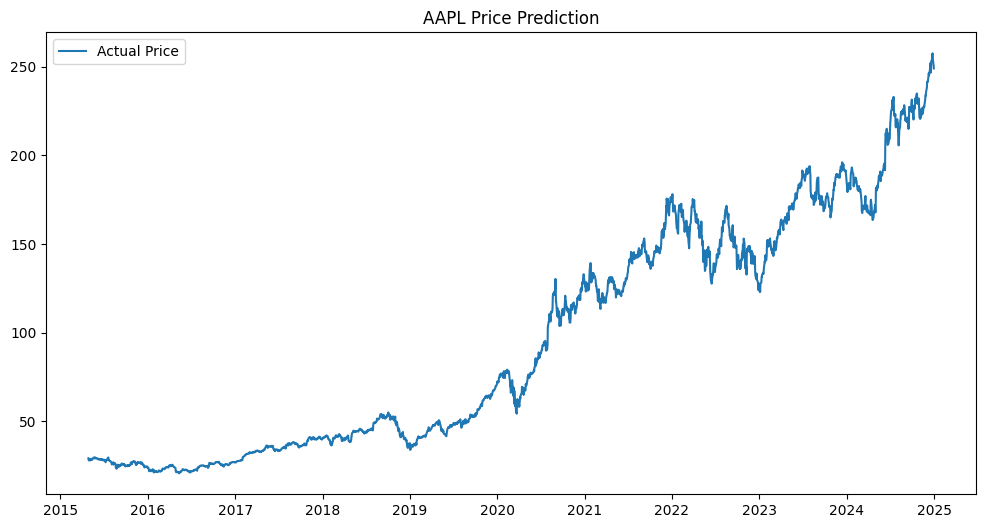

In [7]:
# (Simplified prediction logic for brevity)
predictions = model.predict(x_train)
# Map back to original scale (this requires careful handling of the scaler's dimensions)
# For a full notebook, you'd create a separate scaler for the 'Close' column only.

plt.figure(figsize=(12,6))
plt.plot(data.index[prediction_days:], data['Close'][prediction_days:], label="Actual Price")
plt.title(f"{ticker} Price Prediction")
plt.legend()
plt.show()

In [10]:
!pip install streamlit pyngrok yfinance tensorflow pandas matplotlib scikit-learn


In [20]:
%%writefile app.py
import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 1. Page Configuration
st.set_page_config(page_title="LSTM Stock Predictor", layout="wide")
st.title("📈 AI Stock Price Trend Predictor")
st.markdown("This dashboard uses an **LSTM Neural Network** trained on Price, MA20, and RSI.")

# 2. Load Model (Cached to prevent reload lag)
@st.cache_resource
def load_stock_model():
    # Ensure 'stock_model.h5' is in your directory
    return load_model('stock_model.h5')

try:
    model = load_stock_model()
except Exception as e:
    st.error(f"Error loading model: {e}")
    st.stop()

# 3. Sidebar User Inputs
ticker = st.sidebar.text_input("Enter Ticker Symbol", value="AAPL")
start_date = "2020-01-01"

# 4. Fetch Data
@st.cache_data
def fetch_data(symbol):
    # We fetch extra days to calculate the 20-day Moving Average and RSI
    df = yf.download(symbol, start=start_date)
    return df

data = fetch_data(ticker)

if data.empty:
    st.warning("No data found for this ticker.")
    st.stop()

# 5. Feature Engineering (Must match Training Step 2)
data['MA20'] = data['Close'].rolling(window=20).mean()
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))
data.dropna(inplace=True)

# 6. Display Historical Trends
st.subheader(f"Historical Data: {ticker}")
st.line_chart(data['Close'])

# 7. Prediction Logic
if st.button("Predict Next Day Price"):
    # Select features
    features = ['Close', 'MA20', 'RSI']
    recent_data = data[features].tail(60).values  # Last 60 days

    # --- DUAL SCALING APPROACH ---
    # Scaler for the 3 input features
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = feature_scaler.fit_transform(recent_data)

    # Dedicated scaler for 'Close' (Target) to avoid the $0 prediction bug
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler.fit(recent_data[:, 0].reshape(-1, 1))

    # Reshape for LSTM: [Samples, TimeSteps, Features] -> [1, 60, 3]
    X_input = np.reshape(scaled_features, (1, 60, 3))

    # Run Prediction
    prediction_scaled = model.predict(X_input)

    # Inverse Transform using the Target Scaler
    final_price = target_scaler.inverse_transform(prediction_scaled)[0][0]

   # 8. Visualization of Results
    col1, col2 = st.columns(2)

    # Extract scalar values to avoid TypeErrors
    last_close = float(data['Close'].iloc[-1])
    prediction_val = float(final_price)
    price_diff = prediction_val - last_close

    with col1:
        st.metric("Current Price", f"${last_close:.2f}")
    with col2:
        st.metric("Predicted Next Day", f"${prediction_val:.2f}", delta=f"{price_diff:.2f}")
    # Plot Prediction Line
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(data.index[-50:], data['Close'][-50:], label="Recent Actual Price", color="blue")
    ax.axhline(y=final_price, color='red', linestyle='--', label=f"Prediction: ${final_price:.2f}")
    ax.set_title(f"{ticker} Forecast Analysis")
    ax.legend()
    st.pyplot(fig)

    st.success("Disclaimer: This is for educational purposes only. Market risks are real!")

Overwriting app.py


In [21]:
from pyngrok import ngrok

# Replace 'YOUR_AUTHTOKEN_HERE' with your actual token
NGROK_AUTH_TOKEN = "30YB6uJnSxTFTgPOfLh6Nrv9zHj_41RrKqwdXg7H8eTjd2ax8"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [24]:
import os

# Run streamlit in the background
os.system("nohup streamlit run app.py --server.port 8501 &")

# Open a HTTP tunnel on port 8501
public_url = ngrok.connect(8501, proto="http")

print("--- DEPLOYMENT SUCCESSFUL ---")
print(f"Your app is live at: {public_url}")
print("------------------------------")

--- DEPLOYMENT SUCCESSFUL ---
Your app is live at: NgrokTunnel: "https://9aed-34-86-209-0.ngrok-free.app" -> "http://localhost:8501"
------------------------------
